# Overview

This is a notebook for training models to submit predictions to the "Binary Classification with a Bank Dataset" Kaggle competition ([playground-series-s5e8](https://www.kaggle.com/competitions/playground-series-s5e8)).

Synthetic data is used for this playground competition, and the objective is to, for each client (with a corresponding `id`) in the test set, predict the probability that the client will subscribe to a bank term deposit. Note that while the target represented by `y` is binary (i.e. the client either subscribes or does not subscribe), the predictions are about probabilities, and so their values lie between 0 and 1.

# Setup

Let's first do some initial setup to import what we'll need, and set some configurations that will make it easier to check the output.

In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_colwidth', None) # Display full column content
pd.set_option('display.width', 1000) # Set larger display width

Now, let's read the data, and set some variables that we'll use later on.

In [2]:
# Read data files
input_filepath = '/kaggle/input'
train_data = pd.read_csv(input_filepath + '/playground-series-s5e8/train.csv')
test_data = pd.read_csv(input_filepath + '/playground-series-s5e8/test.csv')

# Set index
train_data.set_index('id', inplace=True)
test_data.set_index('id', inplace=True)

# Get numeric and categorical columns from training data (which should be the same for test data)
numeric_col_names = train_data.select_dtypes(include='number').columns.to_series()
categorical_col_names = train_data.select_dtypes(include='object').columns.to_series()
assert numeric_col_names.size + categorical_col_names.size == train_data.shape[1]

# Set target column
target_col='y'
# Drop 'y' column from numeric column names
numeric_col_names.drop(target_col, inplace=True)

# Set an arbitrary value that can be used to specify the random_state later
random_state = 11

It will be helpful to first get a basic idea of how many rows and columns are in the dataset, and whether there are any missing data.

In [3]:
def print_basic_info(dataset_name, dataset):
    print('\n' + dataset_name + ' shape:', dataset.shape)
    print(dataset_name + ' missing values:')
    print(dataset.isnull().sum())

# Take a look at training dataset
print_basic_info('Training dataset', train_data)
# Take a look at test dataset
print_basic_info('Test dataset', test_data)


Training dataset shape: (750000, 17)
Training dataset missing values:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Test dataset shape: (250000, 16)
Test dataset missing values:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64


Both the training and test datasets are not small, and there are no missing values in either of them.

# Examining the data

Let's examine the data more closely with the help of some charts.

It appears there is more than six times more data on 'y=0' than there is data on 'y=1'.<br>
The imbalance is not that extreme, so perhaps it won't be necessary to try to address it before model training.

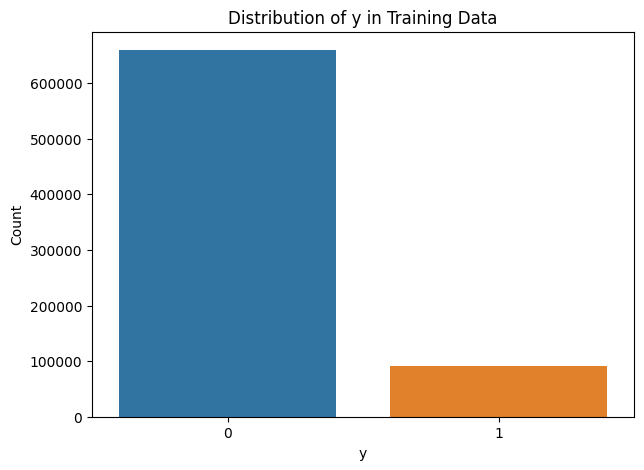

In [4]:
# See the distribution of 'y' in the training data
plt.figure(figsize=(7, 5))
sns.countplot(x='y', data=train_data)
plt.title('Distribution of y in Training Data')
plt.xlabel('y')
plt.ylabel('Count')
plt.show()

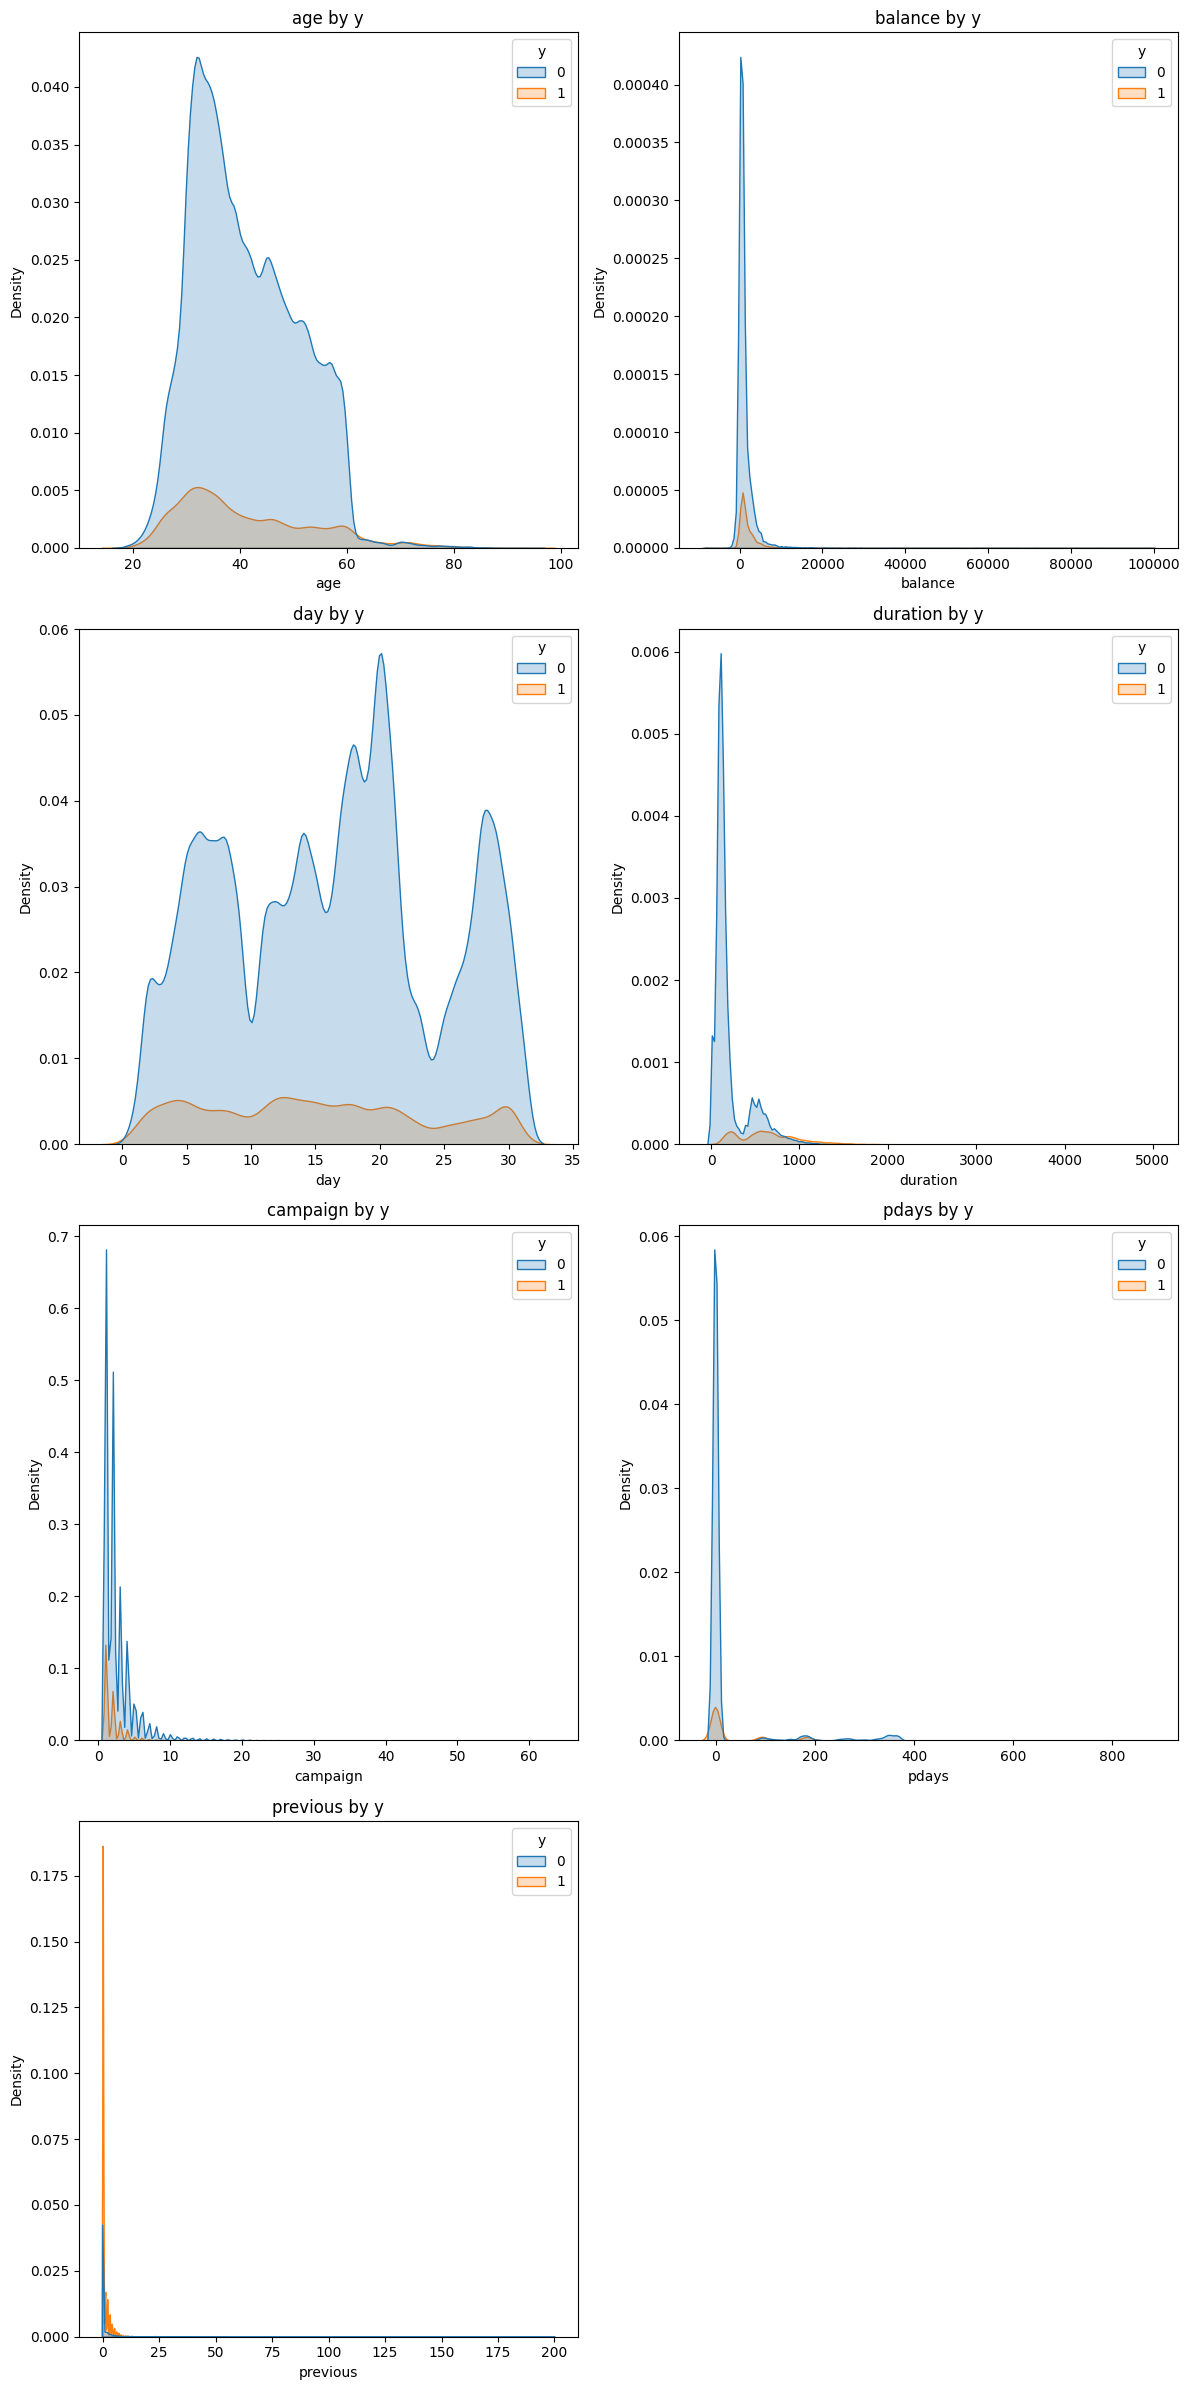

In [5]:
# KDE plots of numerical features with target variable as hue
plt.figure(figsize=(12, 24))
for i, col in enumerate(numeric_col_names, start=1):
    plt.subplot(4, 2, i)
    sns.kdeplot(data=train_data, x=col, hue='y', shade=True)
    plt.tight_layout()
    plt.title(f'{col} by y')

A correlation matrix of the numerical features indicate that there is a moderate (positive) correlation between the 'pdays' and 'previous' features. Perhaps it may be good to consider removing one of the features from training.

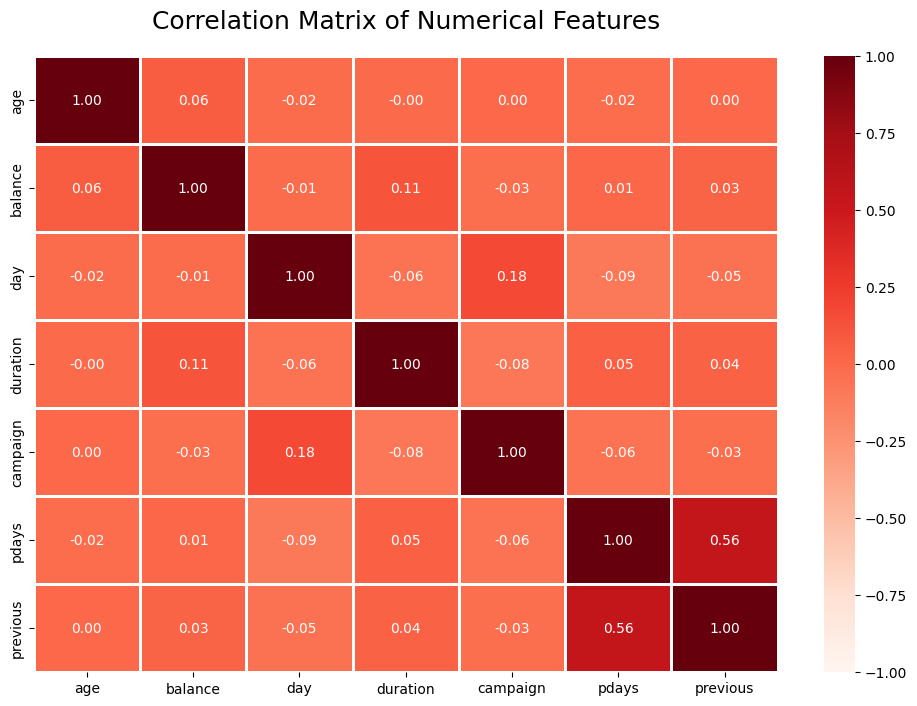

In [6]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    train_data[numeric_col_names].corr(),
    cmap='Reds',
    annot=True,
    linewidths=2,
    fmt='.2f',
    vmin=-1,
    vmax=1
)
plt.title('Correlation Matrix of Numerical Features', fontsize=18, pad=20)
plt.show()

Analyzing a crosstabluation of categorical features with the target variable ('y'), the following insights can be derived:
- for the 'job' feature, the ratio of 'y=1' to 'y=0' is highest for the 'student' job type (ratio: ~0.52), with 'retired' (ratio: ~0.33), 'unemployed' (ratio: ~0.22) and 'management' (ratio: ~0.18) job types also having relatively high ratios. The ratios of the remaining job types are in the 0.05 to 0.15 range.
- for the 'marital' feature, the ratio of 'y=1' to 'y=0' is the highest for 'single' (ratio: ~0.20), whereas the ratios for 'married' (ratio: ~0.11) and 'divorced' (ratio: ~0.13) are considerably lower.
- for the 'month' feature, it would probably be better to combine it with the 'day' feature
- for the 'poutcome' feature, the ratio of 'y=1' to 'y=0' is highest for 'success' (by a large margin), which is not surprising, as if the previous marketing campaign was a success, it is likely that the customer would sign up for a new term deposit.

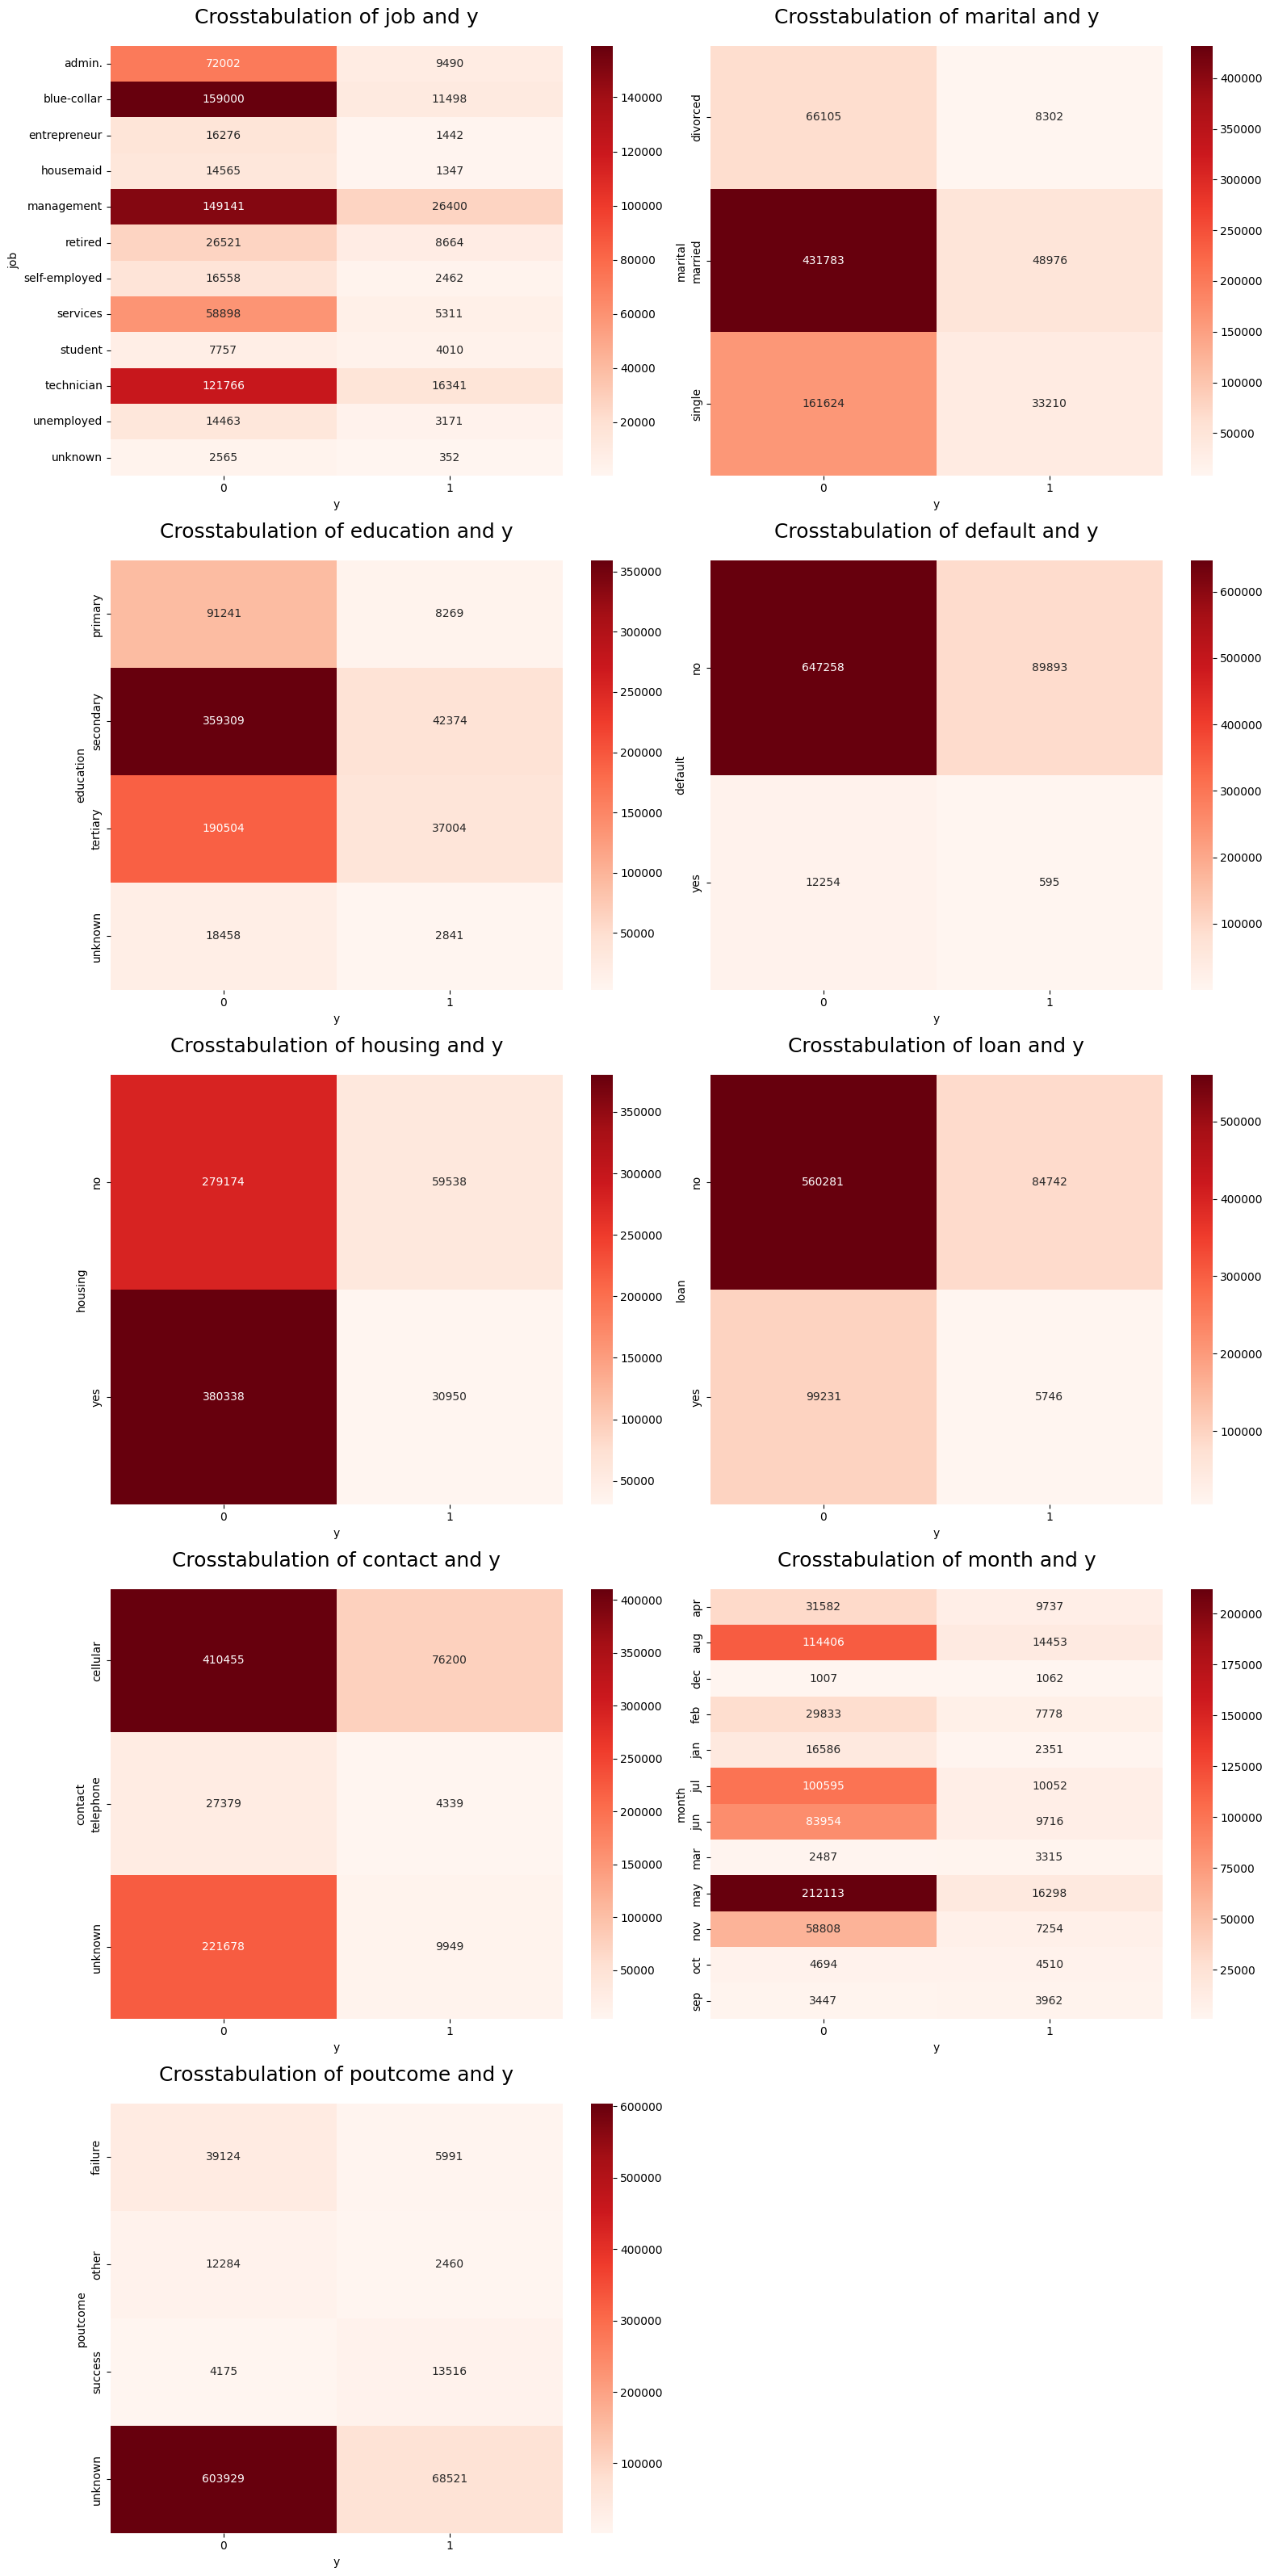

In [7]:
# Crosstabulation of categorical features with target variable
plt.figure(figsize=(16, 32))
for i, col in enumerate(categorical_col_names, start=1):
    plt.subplot(5, 2, i)
    crosstab = pd.crosstab(train_data[col], train_data['y'])
    sns.heatmap(crosstab, cmap='Reds', annot=True, fmt='d')
    plt.tight_layout()
    plt.title(f'Crosstabulation of {col} and y', fontsize=18, pad=20)

# Data Preprocessing

In the data preprocessing stage, we'll prepare the data for training, including handling processing to try utilizing some of the insights derived earlier.

First, let's prepare the dataframes that will be used for training and prediction.
We'll use a cross-validation function ([GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) provided by the [scikit-learn](https://scikit-learn.org/) library for training later, so all rows of the dataset retrieved from the train.csv file will be used for:
- `X_train`: the input data (features) used for training
- `y_train`: the target values corresponding to `X_train`

Likewise, all rows retrieved from the test.csv file will be used for:
- `X_test`: the input data (features) used for making predictions about the target values for the test dataset

In [8]:
# Prepare dataframes that will be used for training and prediction
X_train = train_data.drop([target_col], axis=1)
y_train = train_data[target_col]
X_test = test_data

Next, let's:
- *update* values for the **'pdays'** column so that all of the '-1' sentinel values (used for indicating that the client was never previously contacted) are replaced with a value that is more appropriate for training; while '-1' is close to '0', the latter means that the client was just previously contacted 0 days ago, which is very different from the client never having been contacted, so the maximum of the pdays values found may be an appropriate replacement for the sentinel values
- *combine* the **'month'** and **'day'** columns for the last contact date into a numerical value that can be more easily trained on
- *replace* the **'poutcome'** categorical column (potential values: 'success', 'failure', 'other', 'unknown') with a simpler boolean one that simply indicates whether the previous marketing campaign was a success
- *replace* the **'contact'** categorical column (potential values: 'cellular', 'telephone', 'unknown') with a simpler boolean one that simply indicates whether there is a known contact
- *replace* the **'marital'** categorical column (potential values: 'single', 'married', 'divorced') with a simpler boolean one that simply indicates whether the status is 'single'
- *replace* the **'job'** categorical column (that has numerous potential values) with two columns:
    - one new column for indicating whether the client is a student, since 'student' was found to have a considerably higher ratio of 'y=1' to 'y=0' compared to other job types
    - one new column for indicating whether the client is 'retired', 'management' or 'unemployed', job types which were also found to have high ratios of 'y=1' to 'y=0' compared with remaining job types

In [9]:
# Replace all '-1' sentinel values in the 'pdays' column with the maximum of the 'pdays' values
# found from the training data
train_pdays_max = X_train['pdays'].max()
X_train['pdays'] = X_train['pdays'].apply(lambda x: x if x != -1 else train_pdays_max)
X_test['pdays'] = X_test['pdays'].apply(lambda x: x if x != -1 else train_pdays_max)

# Combine 'month' and 'day' values into one column that will replace the original two columns
train_data_months = pd.to_datetime(X_train['month'], format='%b').dt.month
test_data_months = pd.to_datetime(X_test['month'], format='%b').dt.month
last_contact_month_multiplier = 100
last_contact_day_multiplier = last_contact_month_multiplier / (31 + 1)
X_train['last_contact_date_proxy'] = train_data_months * last_contact_month_multiplier + X_train['day'] * last_contact_day_multiplier
X_test['last_contact_date_proxy'] = test_data_months * last_contact_month_multiplier + X_test['day'] * last_contact_day_multiplier

# Add a column to replace the 'poutcome' column; the new one simply indicates whether the
# previous marketing campaign was a success
X_train['previous_marketing_campaign_successful'] = (X_train['poutcome'] == 'success').astype(object)
X_test['previous_marketing_campaign_successful'] = (X_test['poutcome'] == 'success').astype(object)

# Add a column to replace the 'contact' column; the new one simply indicates whether there
# is a known contact
X_train['has_known_contact'] = (X_train['contact'] != 'unknown').astype(object)
X_test['has_known_contact'] = (X_test['contact'] != 'unknown').astype(object)

# Add a column to replace the 'marital' column; the new one simply indicates whether the marital
# status is 'single'
X_train['marital_status_single'] = (X_train['marital'] == 'single').astype(object)
X_test['marital_status_single'] = (X_test['marital'] == 'single').astype(object)

# Add two columns to replace the 'job' column: 
# - (1) one that indicates simply whether the client is a student, and
# - (2) one that indicates whether the job type is one that was found to typically have a higher 
#       ratio of people subscribing to a term deposit to people not subscribing to a term deposit
#       (i.e. higher ratio of 'y=1' to 'y=0')
X_train['is_student'] = (X_train['job'] == 'student').astype(object)
X_test['is_student'] = (X_test['job'] == 'student').astype(object)
high_ytn_ratio_job_types = [
    'management',
    'retired',
    'unemployed',
]
X_train['high_ytn_ratio_job_type'] = (X_train['job'].isin(high_ytn_ratio_job_types)).astype(object)
X_test['high_ytn_ratio_job_type'] = (X_test['job'].isin(high_ytn_ratio_job_types)).astype(object)

# Drop from training and test data the columns that are no longer needed after the new columns above
# have been added
cols_to_drop = [
    'day',
    'month',
    'poutcome',
    'contact',
    'marital',
    'job',
]
X_train.drop(cols_to_drop, axis=1, inplace=True)
X_test.drop(cols_to_drop, axis=1, inplace=True)

Let's also drop the 'previous' feature as we previously found there to be a moderate correlation between the 'pdays' and 'previous' features.

In [10]:
X_train.drop(['previous'], axis=1, inplace=True)
X_test.drop(['previous'], axis=1, inplace=True)

Let's now resync our `numeric_col_names` and `categorical_col_names` variables with the new set of columns, and check that their total size is as expected (i.e. it matches the number of columns of the training data).

In [11]:
# Get numeric and categorical column names for training data again, and check that
# the total number of numeric and categorical columns is as expected
numeric_col_names = X_train.select_dtypes(include='number').columns.to_series()
categorical_col_names = X_train.select_dtypes(include='object').columns.to_series()
assert numeric_col_names.size + categorical_col_names.size == X_train.shape[1]

## Capping Outliers

To prevent any skewing from outliers, outliers will not be removed, but they will be capped for some of the features so that all their values do not exceed a lower and upper threshold for both the training and test datasets. Applying a multiplier (like 1.5) to the interquartile range, and subtracting and adding the result to the first and third quantiles, respectively, is a common approach, and one that will be taken here. A more conservative multiplier of 3 will be used to limit the amount of trimming done.

In [12]:
# Cap outliers
num_values_trimmed = []
numeric_cols_to_trim = numeric_col_names.drop([
    # don't trim as values just represent dates spread across a year
    'last_contact_date_proxy',
    # don't trim as a majority of the original values were sentinel values indicating
    # that the client was not previously contacted
    'pdays',
    # don't trim as even large outlier values for the number of contacts made during
    # the current campaign may provide some useful insights to the model
    'campaign',
])
for col in numeric_cols_to_trim:
    first_quartile = X_train[col].quantile(0.25)
    third_quartile = X_train[col].quantile(0.75)
    interquartile_range = third_quartile - first_quartile
    multiplier = 3
    lower_threshold = first_quartile - multiplier * interquartile_range
    upper_threshold = third_quartile + multiplier * interquartile_range
    num_values_trimmed.append({
        'Column': col,
        '# values to be trimmed (train_data)': sum(1 for x in X_train[col] if (x < lower_threshold or x > upper_threshold)),
        '# values to be trimmed (test_data)': sum(1 for x in X_test[col] if (x < lower_threshold or x > upper_threshold)),
        '(min, first_quartile, third_quartile, max)': f'({min(X_train[col]):.1f}, {first_quartile:.1f}, {third_quartile:.1f}, {max(X_train[col]):.1f})',
        '(lower_threshold, upper_threshold)': f'({lower_threshold:.1f}, {upper_threshold:.1f})'
    })
    X_train[col].clip(lower=lower_threshold, upper=upper_threshold, inplace=True)
    X_test[col].clip(lower=lower_threshold, upper=upper_threshold, inplace=True)
pd.DataFrame(num_values_trimmed)

,Column,# values to be trimmed (train_data),# values to be trimmed (test_data),"(min, first_quartile, third_quartile, max)","(lower_threshold, upper_threshold)"
0,age,7,4,"(18.0, 33.0, 48.0, 95.0)","(-12.0, 93.0)"
1,balance,24109,8025,"(-8019.0, 0.0, 1390.0, 99717.0)","(-4170.0, 5560.0)"
2,duration,8848,2850,"(1.0, 91.0, 361.0, 4918.0)","(-719.0, 1171.0)"


## Another Look at Charts

Before we continue further and encode the categorical features, let's take another look at charts of the numeric and categorical features of the training data.

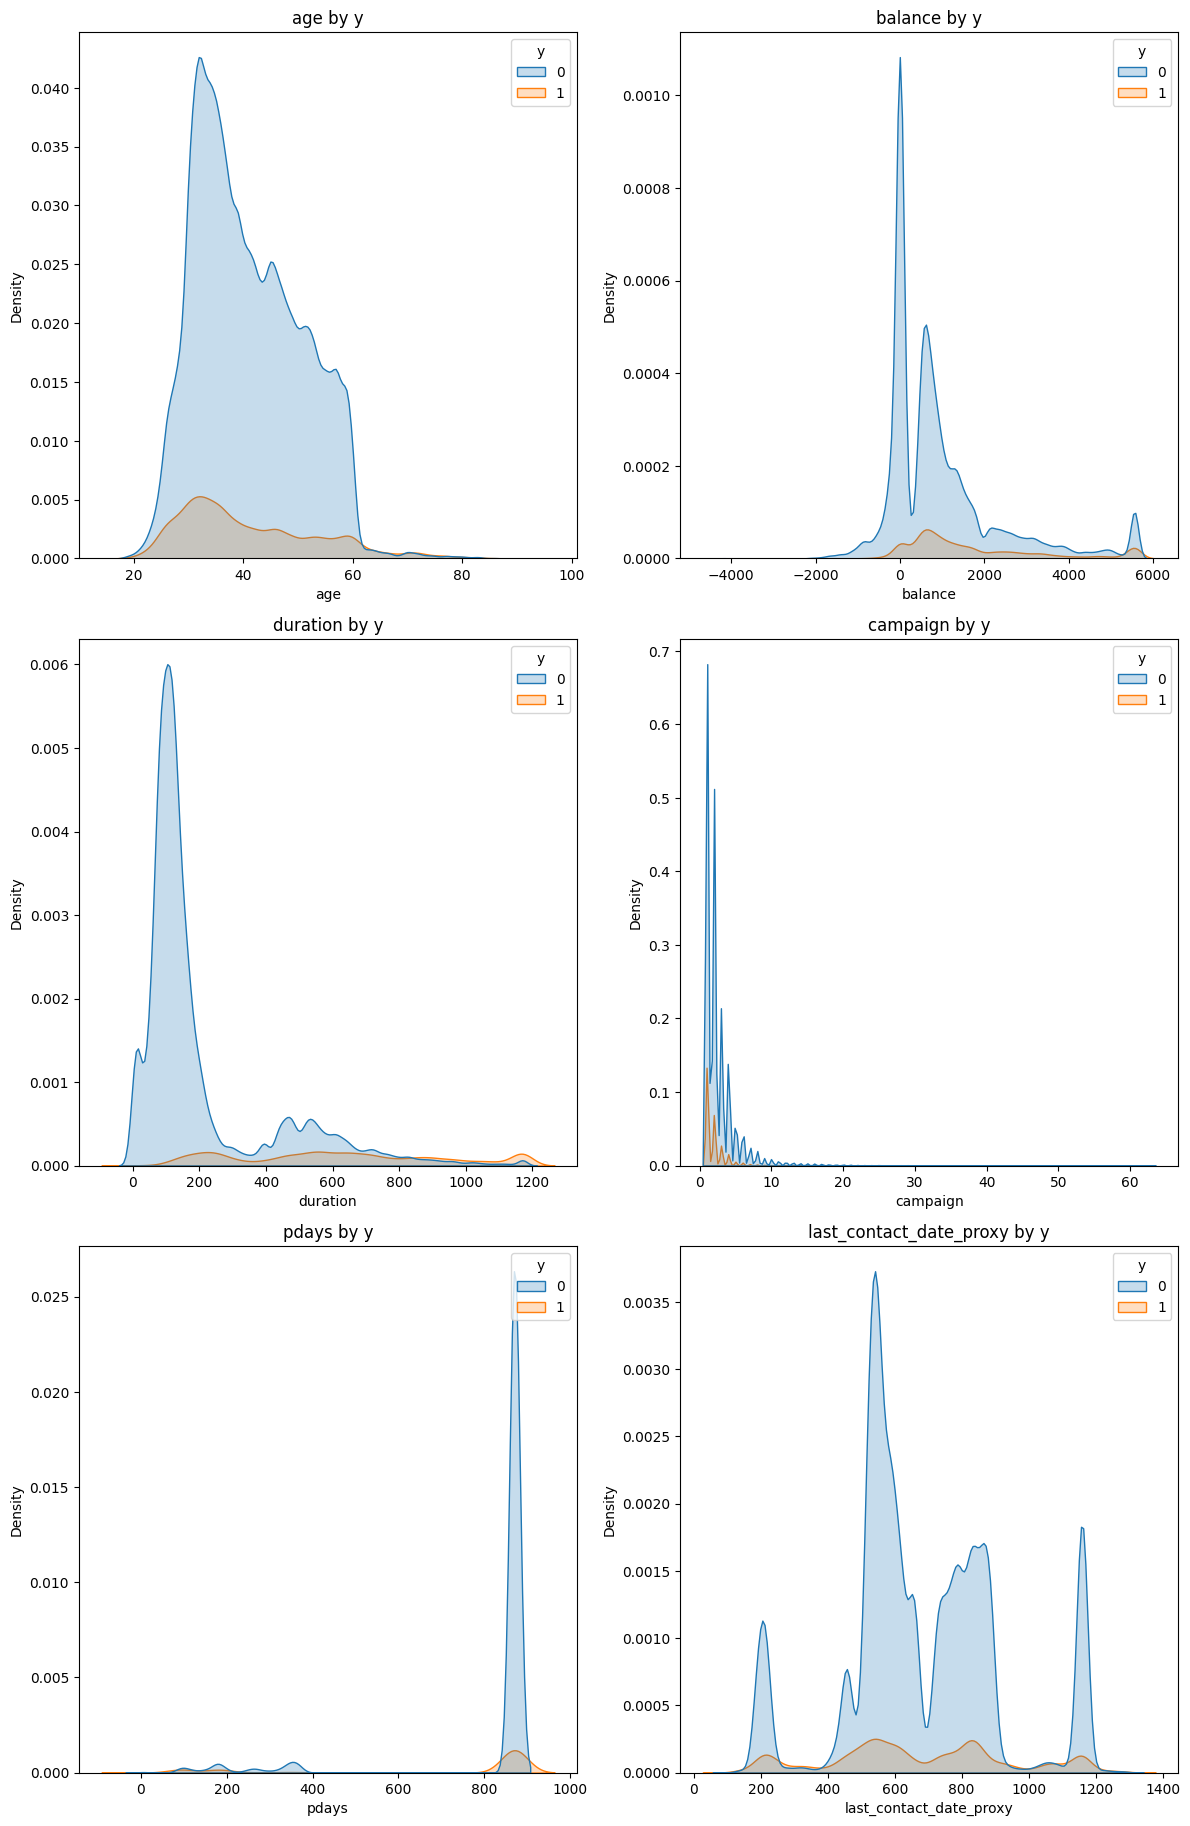

In [13]:
# KDE plots of numerical features with target variable as hue
plt.figure(figsize=(12, 24))
for i, col in enumerate(numeric_col_names, start=1):
    plt.subplot(4, 2, i)
    sns.kdeplot(data=pd.concat([X_train, y_train], axis=1), x=col, hue='y', shade=True)
    plt.tight_layout()
    plt.title(f'{col} by y')

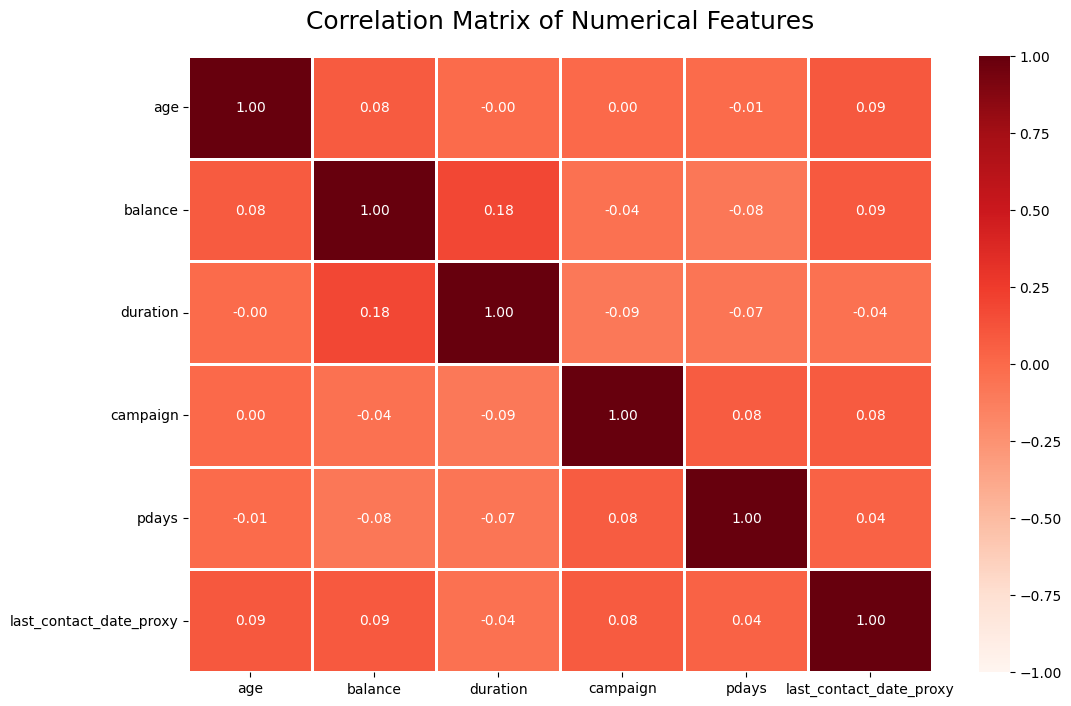

In [14]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    X_train[numeric_col_names].corr(),
    cmap='Reds',
    annot=True,
    linewidths=2,
    fmt='.2f',
    vmin=-1,
    vmax=1
)
plt.title('Correlation Matrix of Numerical Features', fontsize=18, pad=20)
plt.show()

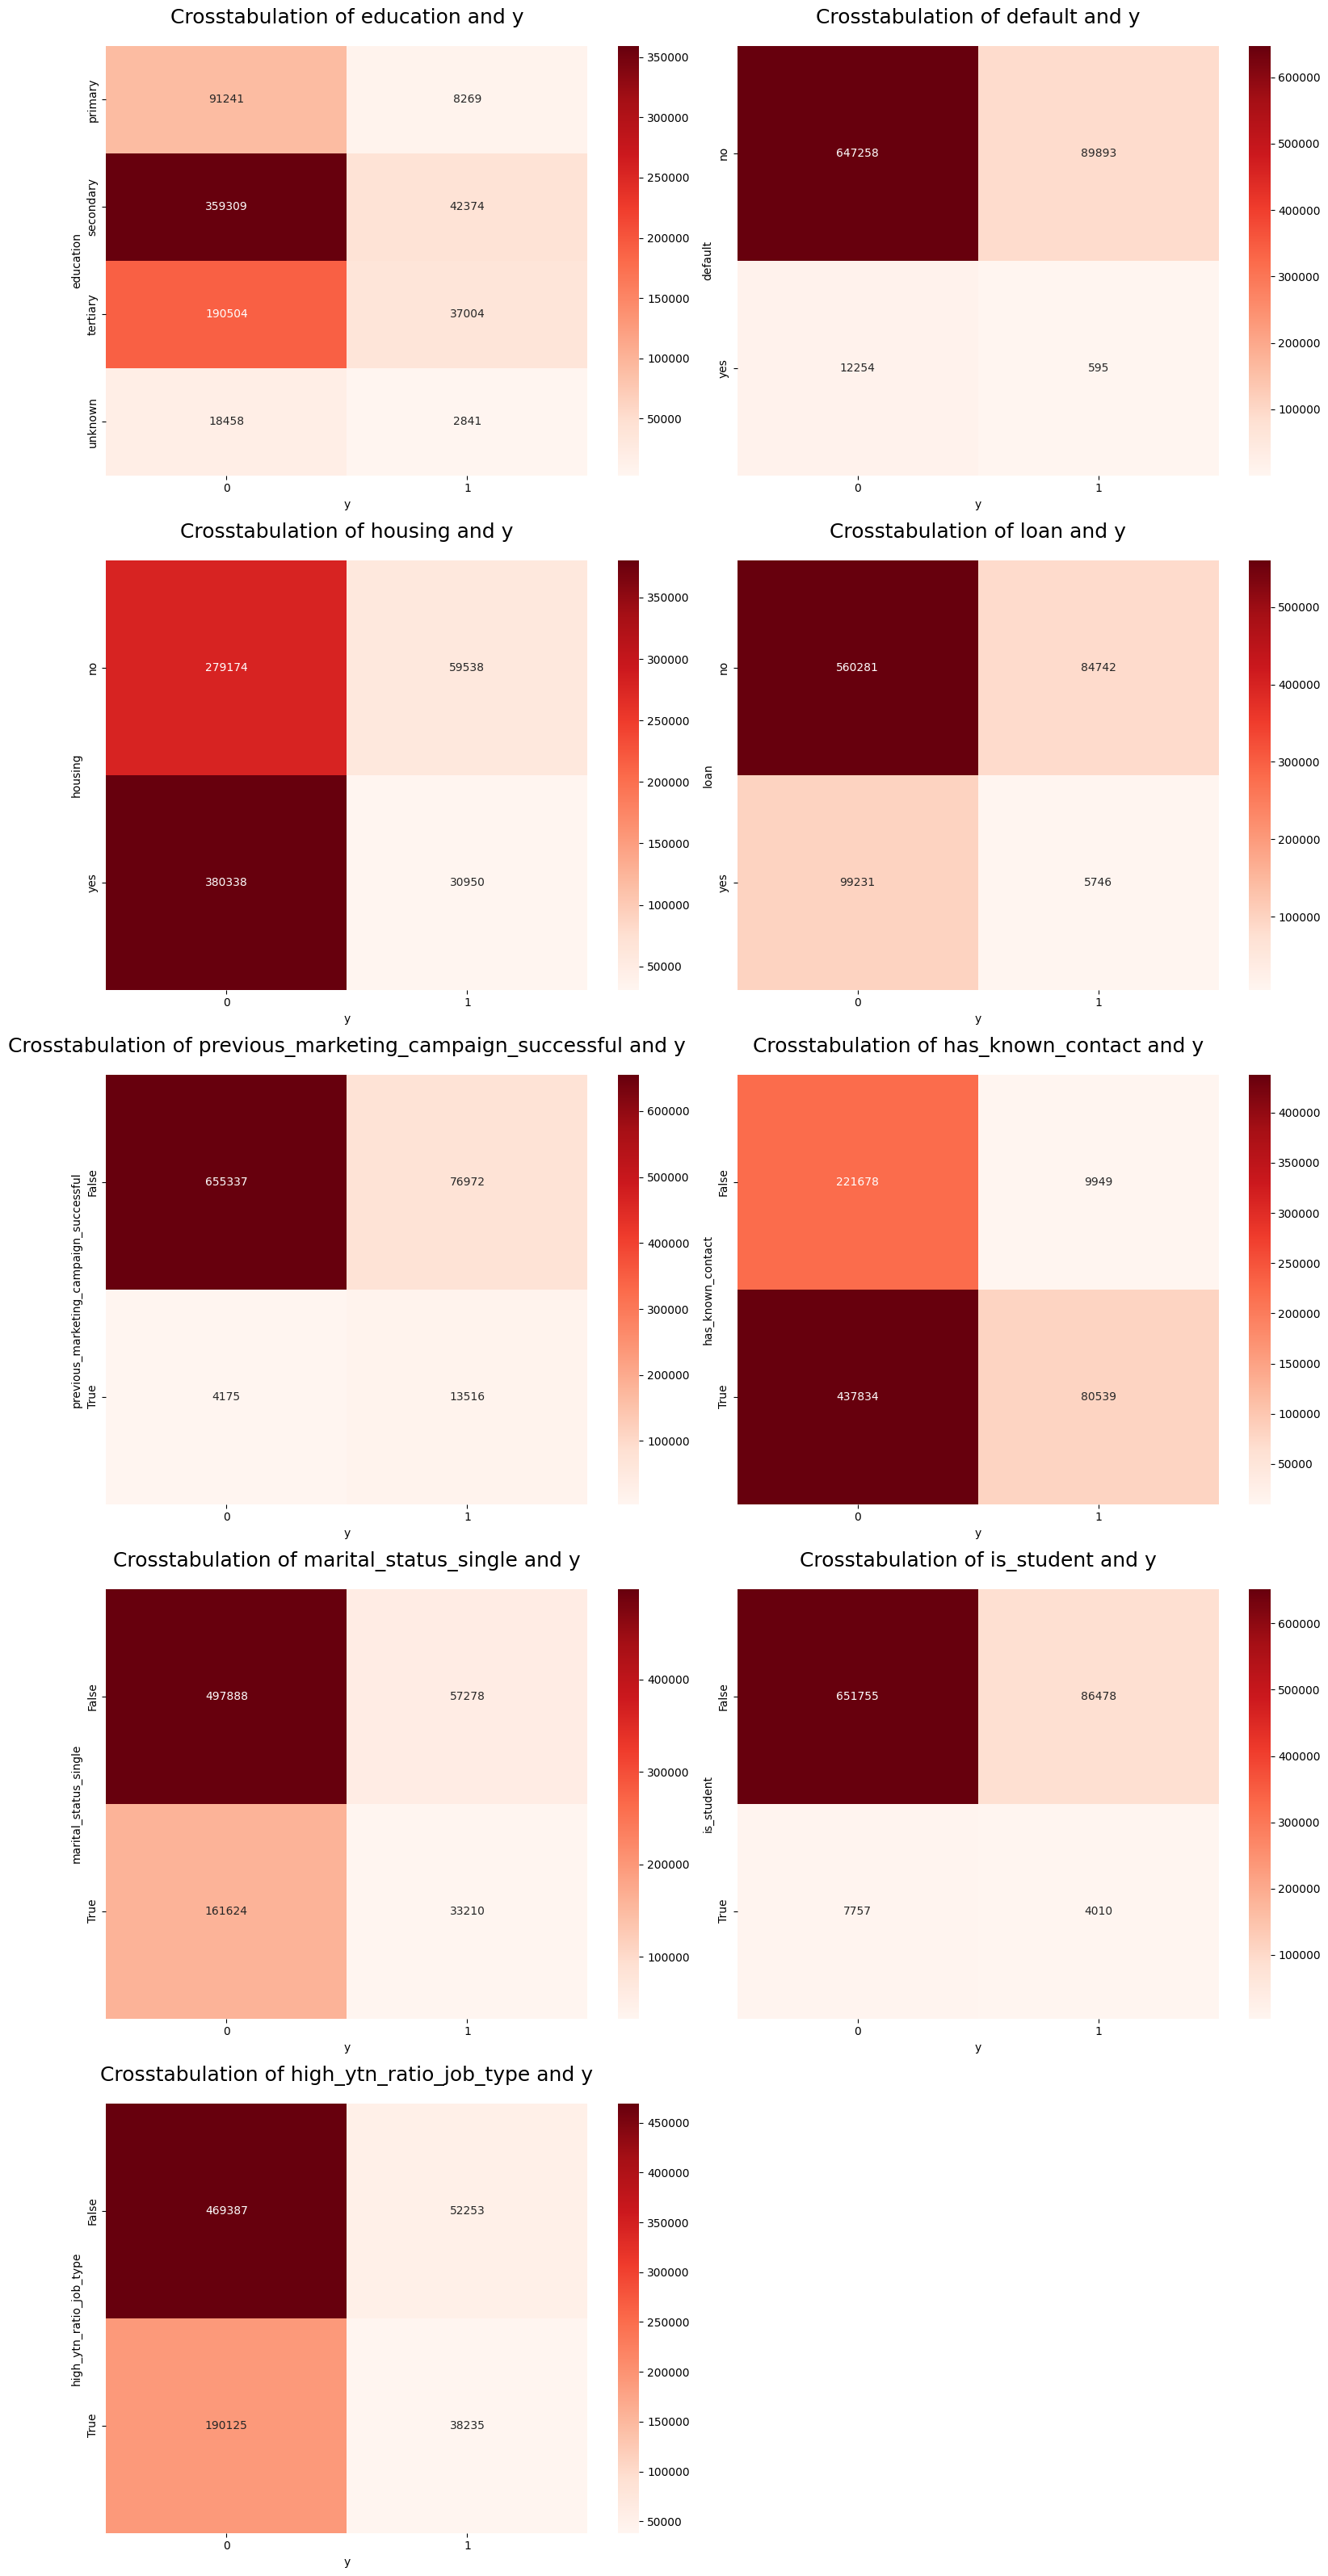

In [15]:
# Crosstabulation of categorical features with target variable
plt.figure(figsize=(16, 32))
for i, col in enumerate(categorical_col_names, start=1):
    plt.subplot(5, 2, i)
    crosstab = pd.crosstab(X_train[col], y_train)
    sns.heatmap(crosstab, cmap='Reds', annot=True, fmt='d')
    plt.tight_layout()
    plt.title(f'Crosstabulation of {col} and y', fontsize=18, pad=20)

## Encoding Categorical Features

For model training, the categorical features are encoded.

In [16]:
# Encode categorical features
X_train = pd.get_dummies(
    X_train,
    columns=categorical_col_names,
    drop_first=True,
    dtype=int
)
X_test = pd.get_dummies(
    X_test,
    columns=categorical_col_names,
    drop_first=True,
    dtype=int
)

## Scaling Features

As some of the models that we will be using require the features to be scaled to obtain more meaningful results, scaled versions of `X_train` and `X_test` are prepared.

In [17]:
# Prepare dataframes of scaled features
std_scaler = StandardScaler()
X_train_scaled = pd.DataFrame(std_scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(std_scaler.transform(X_test), columns=X_test.columns)

# Feature Importance

Now that data preprocessing is complete, let's take a look at how important each feature is in predicting the target variable (`y`) using a random forest.

In [18]:
# Take a look at feature importance using Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=50,
    random_state=random_state
)
rf_regressor.fit(X_train, y_train)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_regressor.feature_importances_
})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
2,duration,0.415680
5,last_contact_date_proxy,0.137750
1,balance,0.122147
0,age,0.085552
12,previous_marketing_campaign_successful_True,0.068852
10,housing_yes,0.040485
3,campaign,0.029019
4,pdays,0.026256
13,has_known_contact_True,0.020059
16,high_ytn_ratio_job_type_True,0.010575


# Model Selection

To choose a model which we'll use to make predictions:
- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) will be used to perform an exhaustive search over various parameter values specified for a model to find the combination of parameters that result in the model's best performance.
- An array of models which we are interested in (along with corresponding parameter values) will be passed to GridSearchCV so that a comparison between the models' performance can be made.

First, let's specify the models (which GridSearchCV refers to as estimators) and the parameter values that we want GridSearchCV to perform a cross-validated parameter grid-search over.

In [19]:
# Define the estimators that will be passed to GridSearchCV for hyperparameter tuning
# Note that the values for the parameter grid have already been adjusted after several iterations
estimator_key = 'estimator'
param_grid_key = 'param_grid'
use_scaled_features_key = 'use_scaled_features'
grid_search_cv_estimators = {
    # 'logistic_reg': {
    #     estimator_key: LogisticRegression(random_state=random_state),
    #     param_grid_key: {
    #         'C': [0.0001, 0.001, 0.1],
    #         'solver': ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky'],
    #         'max_iter': list(range(300, 600, 100))
    #     },
    #     use_scaled_features_key: True
    # },
    # 'random_forest': {
    #     estimator_key: RandomForestRegressor(random_state=random_state),
    #     param_grid_key: {
    #         'n_estimators': list(range(400, 500, 50)),
    #         # 'criterion': ['gini', 'entropy', 'log_loss'],
    #         'max_depth': list(range(1, 2, 1)),
    #     },
    #     use_scaled_features_key: False
    # },
    # 'gradient_boost': {
    #     estimator_key: GradientBoostingRegressor(random_state=random_state),
    #     param_grid_key: {
    #         # 'learning_rate': [0.01, 0.1],
    #         'n_estimators': list(range(100, 200, 100)),
    #         'max_depth': list(range(1, 3, 1))
    #     },
    #     use_scaled_features_key: False
    # },
    'xgb': {
        estimator_key: XGBRegressor(random_state=random_state, eval_metric=['auc']),
        param_grid_key: {
            'learning_rate': np.arange(0.3, 0.5, 0.1),
            'n_estimators': list(range(300, 500, 100)),
            'max_depth': list(range(2, 4, 1)),
        },
        use_scaled_features_key: False
    },
    # 'k-neighbors': {
    #     estimator_key: KNeighborsRegressor(),
    #     param_grid_key: {
    #         'n_neighbors': list(range(6, 8, 2)),
    #         'weights': ['uniform', 'distance']
    #     },
    #     use_scaled_features_key: True
    # },
    # 'support_vector': {
    #     estimator_key: SVC(probability=True, class_weight='balanced', random_state=random_state),
    #     param_grid_key: {
    #         # 'C': [0.01, 0.1],
    #         # 'kernel': ['linear', 'rbf', 'sigmoid'],
    #         # 'gamma': ['scale', 'auto']
    #     },
    #     use_scaled_features_key: True
    # }
}

Next, the models and corresponding parameter grids are passed to GridSearchCV for the search, using ROC AUC as the metric to determine model performance.

In [20]:
# Perform hyperparameter tuning using GridSearchCV
results = []
for estimator_name, estimator in grid_search_cv_estimators.items():
    print(f'Executing GridSearchCV for {estimator_name}..')
    gscv = GridSearchCV(
        estimator[estimator_key],
        estimator[param_grid_key],
        n_jobs=-1,
        scoring='roc_auc'
    )
    X_to_train_on = X_train_scaled if estimator[use_scaled_features_key] else X_train
    gscv.fit(X_to_train_on, y_train)
    results.append({
        'estimator': estimator_name,
        'best_score': gscv.best_score_,
        'best_params': gscv.best_params_
    })
results = pd.DataFrame(results).sort_values(by='best_score', ascending=False)
results

Executing GridSearchCV for xgb..


,estimator,best_score,best_params
0,xgb,0.961066,"{'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 400}"


# Model Training

Let's train a xgb model on the training data using the 'best parameters' found by GridSearchCV.

In [21]:
# Use the parameters found from GridSearchCV to train a xgb model
xgb_params = results[results['estimator']=='xgb']['best_params'].iloc[0]
xgb_regressor = XGBRegressor(
    n_estimators=xgb_params['n_estimators'],
    max_depth=xgb_params['max_depth'],
    learning_rate=xgb_params['learning_rate'],
    eval_metric=['auc'],
    n_jobs=-1,
    random_state=random_state
)
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['auc'], feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.4, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=-1,
             num_parallel_tree=None, random_state=11, ...)

# Prediction and Submission

Using the xgb model trained, we'll make predictions on the test data, and convert the values back to the format that is required for submission to the competition.

In [22]:
# Get predictions of target variable
y_preds = xgb_regressor.predict(X_test).clip(min=0, max=1)
    
# Prepare submission
submission = pd.DataFrame({'id': test_data.index, 'y': y_preds})
submission.to_csv('submission.csv', index=False)
print('Submission file prepared.')

Submission file prepared.
